In [1]:
import numpy as np

In [3]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_trajectories
from mlcolvar.utils.io import create_dataset_from_files


dataset_graph = create_dataset_from_trajectories(
    trajectories=[
        'data/r.dcd',
        'data/p.dcd'
    ],
    top=['data/r.pdb', 
         'data/p.pdb'],
    cutoff=8.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False
)

datamodule_graph = DictModule(dataset_graph, lengths=[1])
print(datamodule_graph)


dataset_ff = create_dataset_from_files(file_names=['data/colvar_r.dat',
                                                   'data/colvar_p.dat'],
                                                   filter_args={'regex': 'd'})

datamodule_ff = DictModule(dataset_ff, lengths=[1])


DictModule(dataset -> DictDataset( "data_list": 1600, "z_table": [6, 9], "cutoff": 8.0, "data_type": graphs ),
		     train_loader -> DictLoader(length=1, batch_size=1600, shuffle=True))
Class 0 dataframe shape:  (800, 24)
Class 1 dataframe shape:  (800, 24)

 - Loaded dataframe (1600, 24): ['time', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'walker', 'labels']
 - Descriptors (1600, 21): ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']


In [4]:
from mlcolvar.core.nn.graph.schnet import SchNetModel

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset_graph.metadata['cutoff'],
                        atomic_numbers=dataset_graph.metadata['z_table'],
                        n_bases=6,
                        n_layers=2,
                        n_filters=32,
                        n_hidden_channels=32
                    )

In [5]:
from mlcolvar.cvs.supervised.deeptda_merged import DeepTDA

model_graph = DeepTDA(n_states=2,
                        n_cvs=1,
                        target_centers=[-7, 7],
                        target_sigmas=[0.2, 0.2],
                        layers=[21, 15, 10, 1],
                        gnn_model=gnn_model)

model_ff = DeepTDA(n_states=2,
                    n_cvs=1,
                    target_centers=[-7, 7],
                    target_sigmas=[0.2, 0.2],
                    layers=[21, 15, 10, 1],
                    gnn_model=None)



/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'gnn_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['gnn_model'])`.


In [6]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cpu',
    max_epochs=5,
    enable_model_summary=False, 
    limit_val_batches=0
)

trainer.fit(model_graph, datamodule_graph)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
list(a)
test = next(iter(a))
inp = test['data_list']
inp

DataBatch(edge_index=[2, 67200], shifts=[67200, 3], unit_shifts=[67200, 3], positions=[11200, 3], cell=[4800, 3], node_attrs=[11200, 2], graph_labels=[1600, 1], n_system=[1600, 1], weight=[1600], batch=[11200], ptr=[1601])

In [8]:
import torch
xxx = inp.get_example(0)
xxx.batch = torch.tensor([0], dtype = torch.long)
xxx

Data(edge_index=[2, 42], shifts=[42, 3], unit_shifts=[42, 3], positions=[7, 3], cell=[3, 3], node_attrs=[7, 2], graph_labels=[1, 1], n_system=[1, 1], weight=[1], batch=[1])

In [9]:
# model_graph.eval()
traced_model = model_graph.to_torchscript('test.pt', method='trace', example_inputs=xxx.to_dict())

In [12]:
from mlcolvar.data.graph.utils import create_dataset_from_configurations
from mlcolvar.data.graph.atomic import AtomicNumberTable, Configuration

numbers = gnn_model.atomic_numbers.cpu().numpy().tolist()
positions = np.random.randn(2, len(numbers), 3)
cell = np.identity(3, dtype=float) * 0.2
graph_labels = np.array([[[0]], [[1]]])
node_labels = np.array([[0]] * len(numbers))
z_table = AtomicNumberTable.from_zs(numbers)

config = [
    Configuration(
        atomic_numbers=numbers,
        positions=positions[i],
        cell=cell,
        pbc=[True] * 3,
        node_labels=node_labels,
        graph_labels=graph_labels[i],
    ) for i in range(2)
]
dataset = create_dataset_from_configurations(
    config, z_table, 0.1, show_progress=False
)

loader = DictModule(
    dataset,
    lengths=(1.0,),
    batch_size=10,
    shuffle=False,
)
loader.setup()

please = next(iter(loader.train_dataloader()))
inp_test = please['data_list']

In [13]:
inp_test.batch = torch.tensor([0], dtype=torch.long)

inp_test

DataBatch(edge_index=[2, 4], shifts=[4, 3], unit_shifts=[4, 3], positions=[4, 3], cell=[6, 3], node_attrs=[4, 2], node_labels=[4, 1], graph_labels=[2, 1], n_system=[2, 1], weight=[2], batch=[1], ptr=[3])

In [14]:
print(model_graph(xxx))
print(model_graph(inp_test))

tensor([[-0.1347]], grad_fn=<DivBackward0>)
tensor([[-1.2945]], grad_fn=<DivBackward0>)


In [15]:
print(model_graph(xxx))
print(model_graph(inp_test))

print(traced_model(xxx))
print(traced_model(inp_test))

loaded_model = torch.jit.load('test.pt')

print(loaded_model(xxx))
print(loaded_model(inp_test))

# EVVIVAAAAAA

tensor([[-0.1347]], grad_fn=<DivBackward0>)
tensor([[-1.2945]], grad_fn=<DivBackward0>)
tensor([[-0.1347]], grad_fn=<DivBackward0>)
tensor([[-1.2945]], grad_fn=<DivBackward0>)
tensor([[-0.1347]], grad_fn=<DivBackward0>)
tensor([[-1.2945]], grad_fn=<DivBackward0>)


In [ ]:
datamodule_ff.setup()

a = datamodule_ff.train_dataloader()
a.dataset['data']

datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
list(a)


[{'data_list': DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])}]

In [ ]:
trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='gpu',
    max_epochs=5,
    enable_model_summary=False, 
    limit_val_batches=0
)

trainer.fit(model_ff, datamodule_ff)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: expand(torch.cuda.FloatTensor{[21]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

In [ ]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model_graph(test)

out_ff = model_ff(dataset_ff['data'])

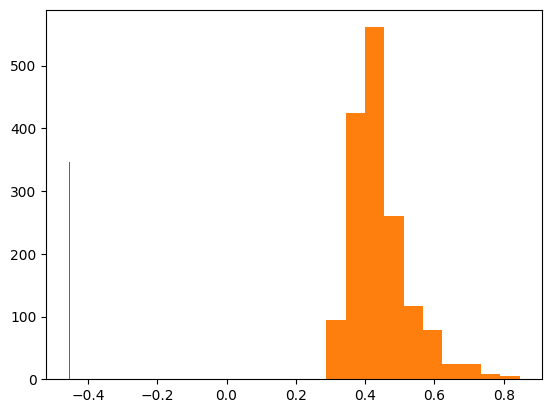

In [ ]:
import matplotlib.pyplot as plt

plt.hist(out_graph.detach().squeeze())
plt.hist(out_ff.detach().squeeze())
plt.show()

In [ ]:
model_graph.to_torchscript('test.pt', method='script')

RuntimeError: 

forward(__torch__.mlcolvar.core.nn.graph.schnet.SchNetModel self, Dict(str, Tensor) data, bool scatter_mean=True) -> Tensor:
Expected a value of type 'Dict[str, Tensor]' for argument 'data' but instead found type 'Union[Tensor, Dict[str, Tensor]]'.
:
  File "/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/cvs/cv.py", line 167
            pass
        elif self.model_type == 'gnn':
            x = self.nn(x)
                ~~~~~~~ <--- HERE
        return x
'DeepTDA.forward_cv' is being compiled since it was called from 'DeepTDA.forward'
  File "/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/cvs/cv.py", line 137
            x = self.preprocessing(x)
    
        x = self.forward_cv(x)
        ~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    
        if self.postprocessing is not None:
